In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import skimage.io
import skimage.transform
from skimage.io import imsave

import time

#from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from visualization_utils import *

from MulticoreTSNE import MulticoreTSNE as TSNE



In [2]:
real_image_file_root = '/Users/sarabeery/Documents/CameraTrapClass/Data/imerit_deer_ims/'

In [3]:
sim_image_file_root = '/Users/sarabeery/Documents/CameraTrapClass/Data/unity_sim_deer/'

In [4]:
#real_db_file = '/Users/sarabeery/Documents/CameraTrapClass/Fixing_CCT_Anns/Corrected_versions/CaltechCameraTrapsBboxes_v2.json'
real_db_file = '/Users/sarabeery/Documents/CameraTrapClass/sim_classification/vizualize_activations/real_deer_visualization.json'
real_bbox_data = json.load(open(real_db_file,'r'))
real_cat_id_to_cat = {cat['id']:cat for cat in real_bbox_data['categories']}
real_ann_id_to_ann = {ann['id']:ann for ann in real_bbox_data['annotations']}



In [5]:
sim_db_file = '/Users/sarabeery/Documents/CameraTrapClass/sim_classification/vizualize_activations/unity_deer_visualization.json'
sim_bbox_data = json.load(open(sim_db_file,'r'))
sim_cat_id_to_cat = {cat['id']:cat for cat in sim_bbox_data['categories']}
sim_ann_id_to_ann = {str(ann['id']):ann for ann in sim_bbox_data['annotations']}



In [6]:
pickle_file = '/Users/sarabeery/Documents/CameraTrapClass/sim_classification/vizualize_activations/train_on_cct/real_deer.p'

real_data = pickle.load(open(pickle_file,'rb'))



In [7]:
pickle_file = '/Users/sarabeery/Documents/CameraTrapClass/sim_classification/vizualize_activations/train_on_cct/unity_deer.p'

sim_data = pickle.load(open(pickle_file,'rb'))



In [8]:
print(real_data.keys())
real_activations = real_data['activations']
real_layer_names = real_data['layer_names']
real_labels = real_data['labels']
real_ann_ids = real_data['ids']
real_logits = real_data['logits']
real_paths = np.asarray([real_image_file_root+real_ann_id_to_ann[idx]['image_id']+'.jpg' for idx in real_ann_ids])
real_bboxes = np.asarray([real_ann_id_to_ann[idx]['bbox'] for idx in real_ann_ids])
print(real_data['logits'][0])
print(real_layer_names)

['activations', 'logits', 'labels', 'ids', 'layer_names']
[-0.2849263  -0.6259589  -0.61326176  4.8219233  -0.4635946  -0.08280746
  0.6108458  -0.7126814  -0.500871   -0.36081842 -0.12899382 -0.3629903
 -0.43690962 -0.05908696 -0.22587422]
['Conv2d_7b_1x1', 'PreLogitsFlatten']


In [9]:
print(sim_data.keys())
sim_activations = sim_data['activations']
sim_layer_names = sim_data['layer_names']
sim_labels = sim_data['labels']
sim_ann_ids = sim_data['ids']
sim_logits = sim_data['logits']
sim_paths = np.asarray([sim_image_file_root+sim_ann_id_to_ann[idx]['image_id']+'.jpg' for idx in sim_ann_ids])
sim_bboxes = np.asarray([sim_ann_id_to_ann[idx]['bbox'] for idx in sim_ann_ids])
print(sim_data['logits'][0])
print(sim_layer_names)

['activations', 'logits', 'labels', 'ids', 'layer_names']
[-0.2610783  -0.26109052 -0.30099297 -0.27534157 -0.31242082 -0.18175657
  4.5430603  -0.3877372  -0.32515118 -0.38734236 -0.27977583 -0.32660732
 -0.2823668  -0.3507747  -0.22884275]
['Conv2d_7b_1x1', 'PreLogitsFlatten']


In [11]:
layer_index = -1
#real
layer = real_activations[layer_index]
print(layer.shape)
image_idxs = range(len(real_labels))
real_X = []
for im_idx in image_idxs:
    vec = layer[im_idx]
    real_X.append(vec.flatten())
    
real_X = np.asarray(real_X)
real_y = np.asarray([0 for i in range(len(real_labels))])

print(real_X.shape, real_y.shape)

#sim
layer = sim_activations[layer_index]
print(layer.shape)
image_idxs = range(len(sim_labels))
sim_X = []
for im_idx in image_idxs:
    vec = layer[im_idx]
    sim_X.append(vec.flatten())
    
sim_X = np.asarray(sim_X)
sim_y = np.asarray([1 for i in range(len(sim_labels))])

print(sim_X.shape, sim_y.shape)

(1000, 1536)
(1000, 1536) (1000,)
(1000, 1536)
(1000, 1536) (1000,)


In [13]:
X = np.concatenate((real_X,sim_X))
y = np.concatenate((real_y,sim_y))
paths = np.concatenate((real_paths,sim_paths))
bboxes = np.concatenate((real_bboxes,sim_bboxes))

print(X.shape, y.shape, paths.shape, bboxes.shape)
print(y[0], y[1500])

(2000, 1536) (2000,) (2000,) (2000, 4)
0 1


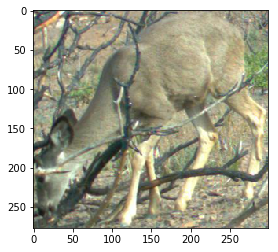

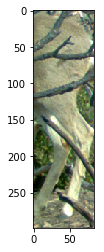

In [14]:
#print(image_idxs)
%matplotlib inline
for im_idx in [1,2]:
    im = get_cropped_im_PIL(paths[im_idx],bboxes[im_idx],input_size=299)
    #im.show()
    
    plt.imshow(im)
    plt.show()

In [15]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))
df['paths'] = paths
df['paths'] = df['paths'].apply(lambda i: str(i))
# df['x'] = bboxes[:,0]
# df['y'] = bboxes[:,1]
# df['w'] = bboxes[:,2]
# df['h'] = bboxes[:,3]
# df['bboxes'] = df['bboxes'].apply(lambda i: str(i))

print('Size of the dataframe: {}'.format(df.shape))


X, y = None, None

Size of the dataframe: (2000, 1538)


In [16]:
rndperm = np.random.permutation(df.shape[0])

In [17]:

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26695558 0.15179341 0.12019939]


0 1


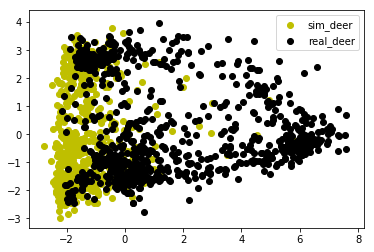

In [18]:
#plot first two PCA dims
%matplotlib inline
colors = ['y','k','c','r','b']
print(df['label'][0],df['label'][1500])
sim_idx = df['label'] == str(1)
plt.scatter(df['pca-one'][sim_idx],df['pca-two'][sim_idx],color='y',label='sim_deer')
real_idx = df['label'] == str(0)
plt.scatter(df['pca-one'][real_idx],df['pca-two'][real_idx],color='k',label='real_deer')

plt.legend()
plt.show()

In [ ]:
#interactive plot
%matplotlib notebook
#%matplotlib inline
plot_idxs = list(range(2000))
embedding = pca_result[plot_idxs,:2]
labels = df['label'][plot_idxs]
paths = df['paths'][plot_idxs]
plot_bboxes = bboxes[plot_idxs]
info = {'real':0,'sim':1} 
plot_embedding(embedding, labels, paths, plot_bboxes, info)
#plt.show()

In [19]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.927864836534


In [26]:
n_sne = 2000

time_start = time.time()
#tsne = TSNE(n_jobs=4)
#Y = tsne.fit_transform(X)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, n_jobs=4)
tsne_pca_results = tsne.fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['tsne-pca-one'] = tsne_pca_results[:,0]
df['tsne-pca-two'] = tsne_pca_results[:,1] 

t-SNE done! Time elapsed: 3.46037793159 seconds


0 1


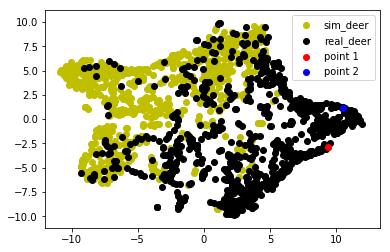

In [27]:
#plot tSNE 
%matplotlib inline
colors = ['y','k','c','r','b']
print(df['label'][0],df['label'][1500])
sim_idx = df['label'] == str(1)
plt.scatter(df['tsne-pca-one'][sim_idx],df['tsne-pca-two'][sim_idx],color='y',label='sim_deer')
real_idx = df['label'] == str(0)
plt.scatter(df['tsne-pca-one'][real_idx],df['tsne-pca-two'][real_idx],color='k',label='real_deer')
plt.scatter(df['tsne-pca-one'][100],df['tsne-pca-two'][100],color='r',label='point 1')
plt.scatter(df['tsne-pca-one'][200],df['tsne-pca-two'][200],color='b',label='point 2')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


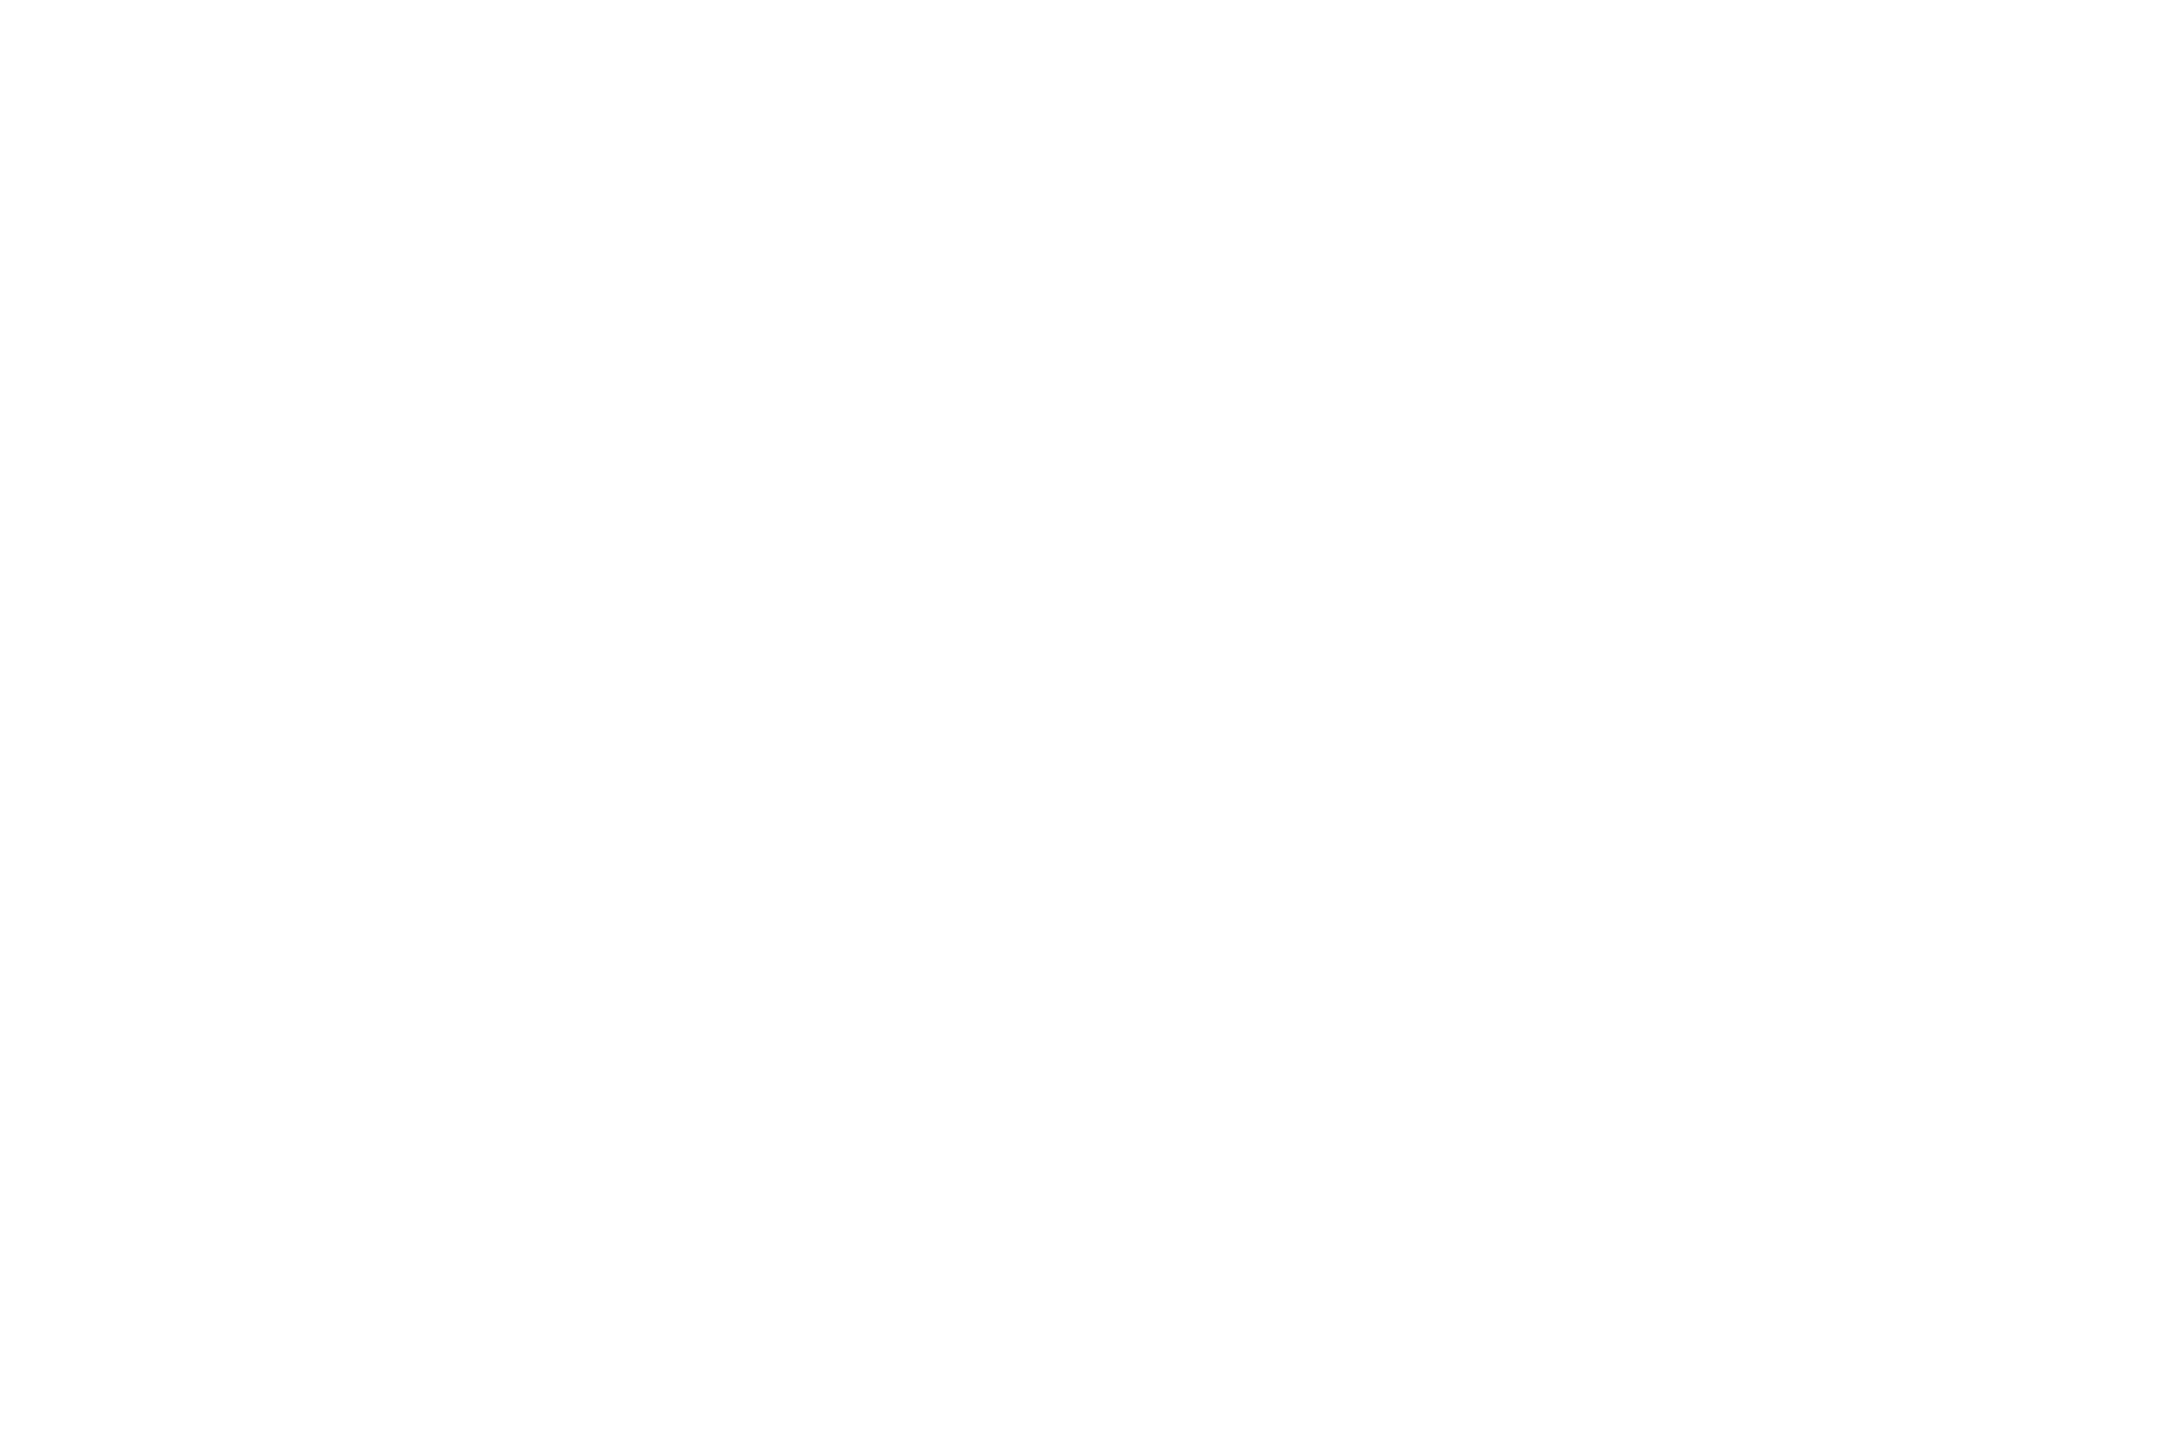

<IPython.core.display.Javascript object>


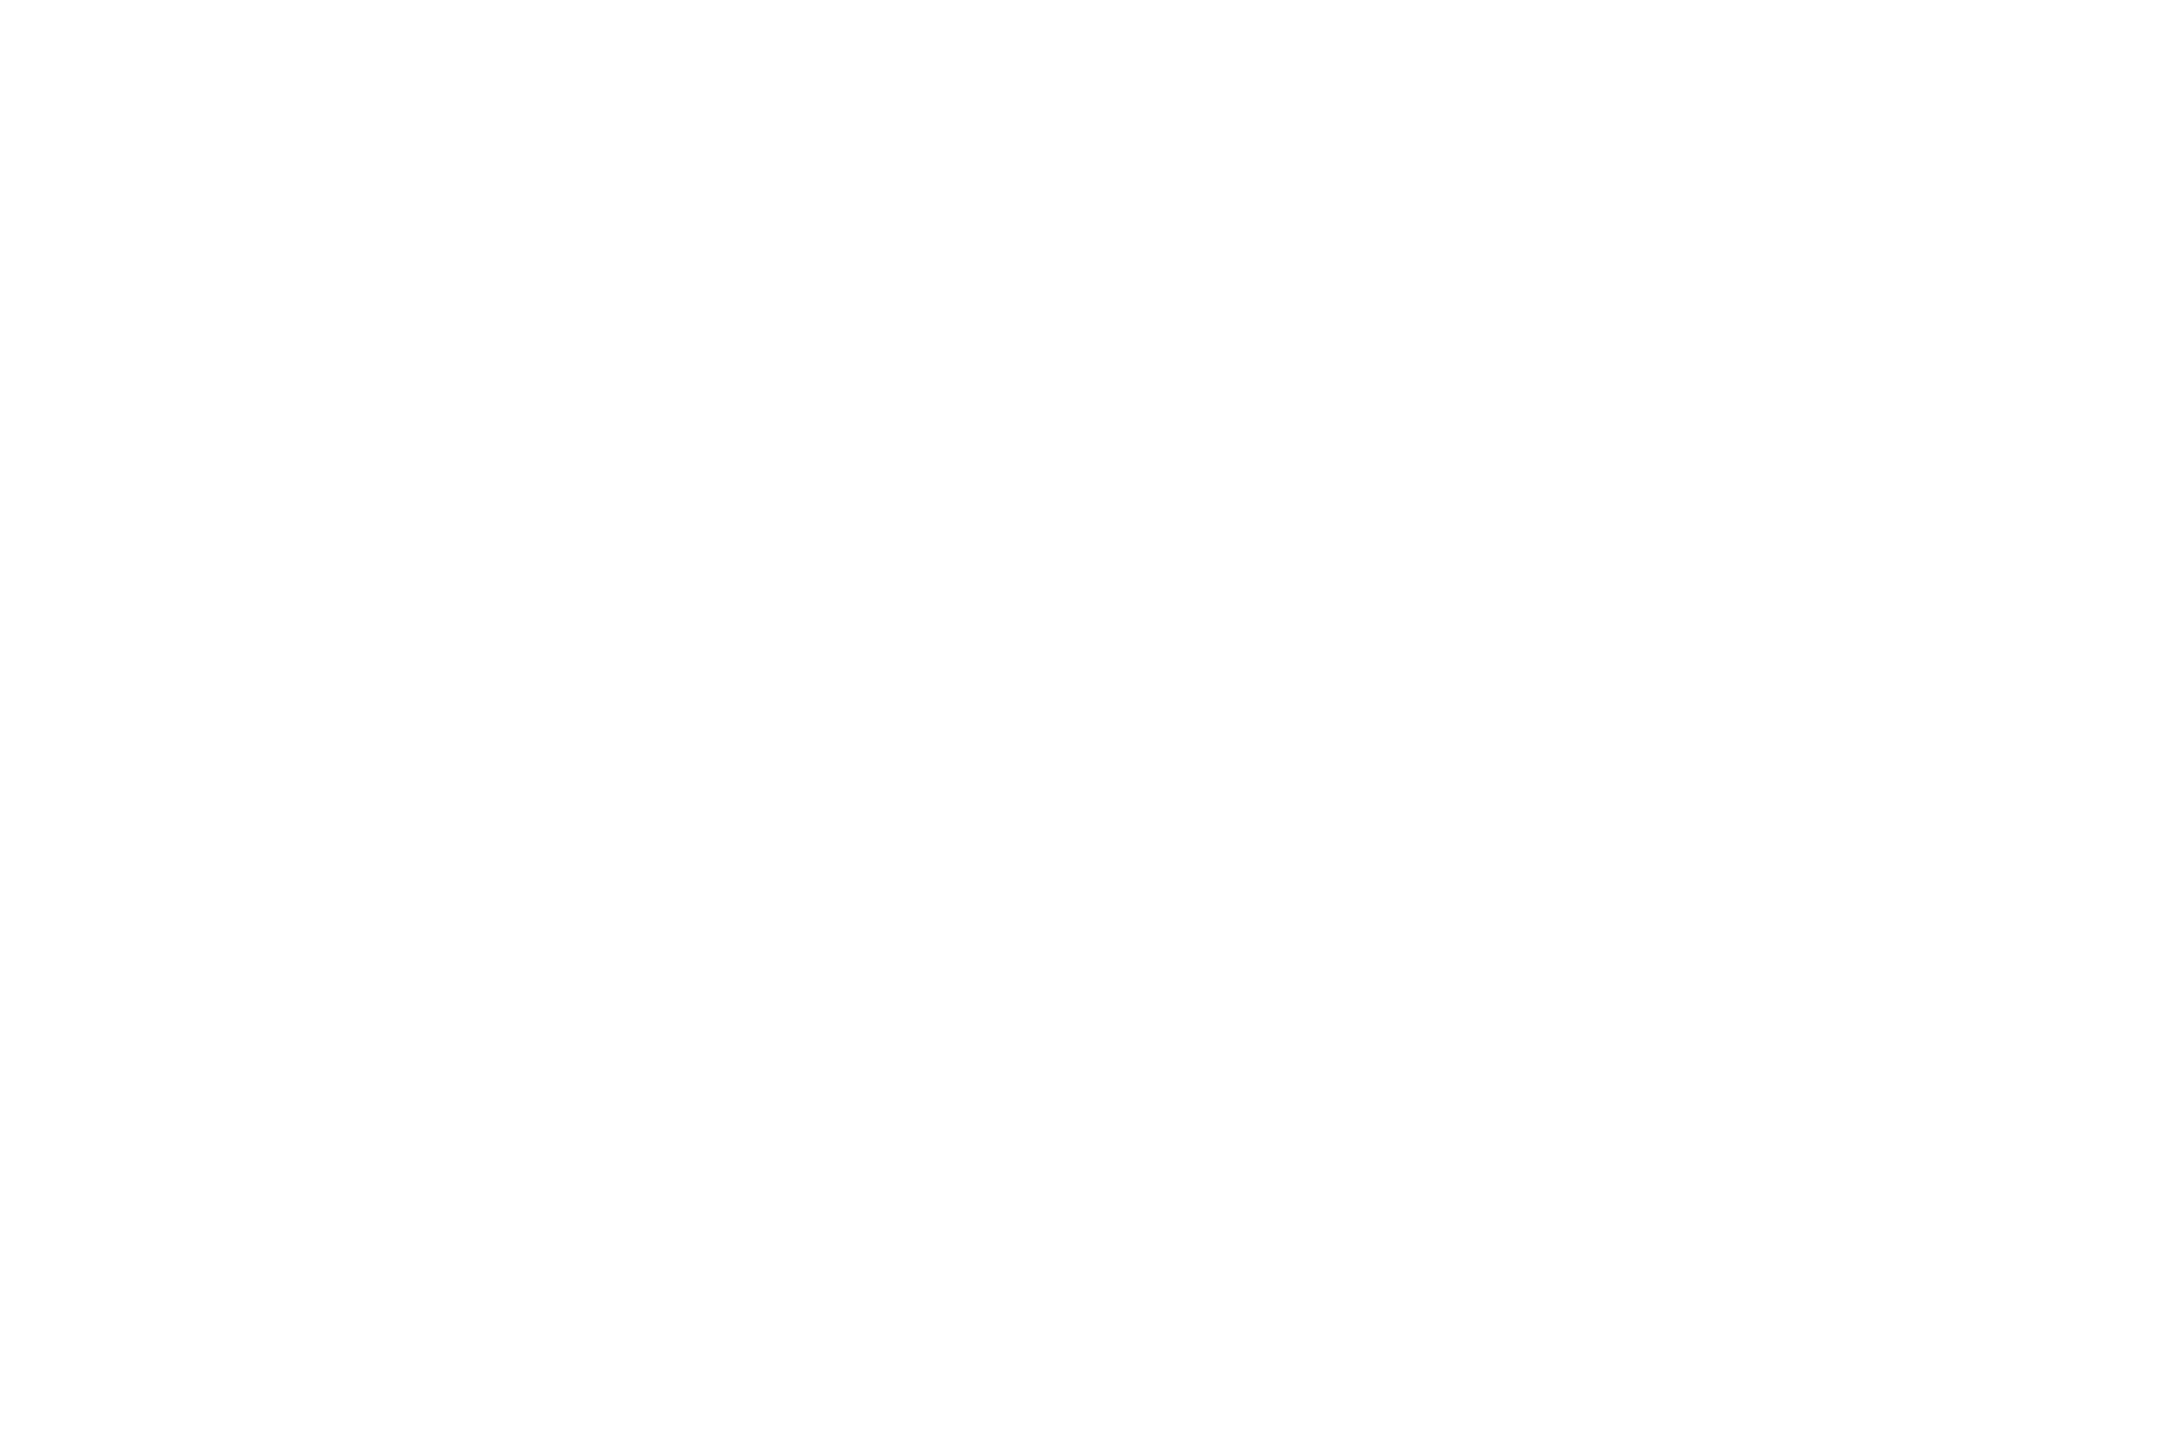

In [28]:
#interactive plot
%matplotlib notebook
#%matplotlib inline
plot_idxs = list(range(2000))
embedding = tsne_pca_results[plot_idxs,:2]
labels = df['label'][plot_idxs]
paths = df['paths'][plot_idxs]
plot_bboxes = bboxes[plot_idxs]
info = {'real':0,'sim':1} 
plot_embedding(embedding, labels, paths, plot_bboxes, info)
#plt.show()